In [5]:
%pip install wordcloud



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from dotenv import load_dotenv


load_dotenv()

True

In [8]:
# Preprocess the sonnet dataset
def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text.split()

# Load the sonnet dataset (one sonnet per line)
file_path = os.path.join(os.environ["SONNETS_DATASET_PATH"], "sonnets.txt")
with open(file_path, "r") as f:
    sonnets = f.readlines()

# Preprocess the dataset
documents = [preprocess_text(sonnet) for sonnet in sonnets]

# Build vocabulary and document-word matrix (DOCD)
vocab = list(set(word for doc in documents for word in doc))
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Convert documents to word indices
# DOCD = np.array([[word_to_index[word] for word in doc] for doc in documents])
DOCD = np.array([word_to_index[word] for word in documents])


# Set parameters
K = 6  # Number of topics
N = len(documents)  # Number of documents (154 for sonnets)
W = len(vocab)  # Number of words in the vocabulary
DLMAX = max(len(doc) for doc in documents)  # Max document length

alpha = 5 * np.ones(K)  # Dirichlet prior for document-topic distribution
beta = 2 * np.ones(W)  # Dirichlet prior for topic-word distribution

# Initialize matrices
Z = np.zeros((N, DLMAX), dtype=int)  # Topic assignments for each word in each document
A = np.tile(alpha, (N, 1))  # Document-topic counts (N x K)
B = np.tile(beta, (K, 1))  # Topic-word counts (K x W)
BSUM = np.sum(B, axis=1)  # Sum of word counts per topic (K x 1)

# Perform Gibbs sampling
iterations = 1000
for T in range(iterations):
    for d in range(N):
        for i in range(len(documents[d])):  # Only iterate over the actual words in each document
            w = DOCD[d, i]  # Word in the document
            zi = Z[d, i]  # Current topic assignment for word w in document d

            if zi > 0:
                A[d, zi] -= 1  # Decrease count of the old topic for document d
                B[zi, w] -= 1  # Decrease count of the word for the old topic
                BSUM[zi] -= 1  # Decrease the sum of word counts for the old topic

            # Calculate the unnormalized distribution for the new topic assignment
            dst = A[d, :] * (B[:, w] / BSUM)  # Probabilities for each topic

            # Sample a new topic based on the distribution
            new_zi = np.random.choice(len(dst), p=dst / np.sum(dst))

            # Update topic assignment and counts
            Z[d, i] = new_zi
            A[d, new_zi] += 1  # Increase count for the new topic in document d
            B[new_zi, w] += 1  # Increase count for the word in the new topic
            BSUM[new_zi] += 1  # Increase the sum of word counts for the new topic

# Display wordcloud for each topic
for k in range(K):
    plt.figure(k)
    plt.clf()
    word_freq = B[k, :]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(vocab, word_freq)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {k+1}")
    plt.axis('off')
    plt.show()

TypeError: unhashable type: 'list'

Loaded 154 documents with vocabulary size 3092
Running LDA with Gibbs sampling...
Completed 100/1000 iterations
Completed 200/1000 iterations
Completed 300/1000 iterations
Completed 400/1000 iterations
Completed 500/1000 iterations
Completed 600/1000 iterations
Completed 700/1000 iterations
Completed 800/1000 iterations
Completed 900/1000 iterations
Completed 1000/1000 iterations
Generating wordclouds...


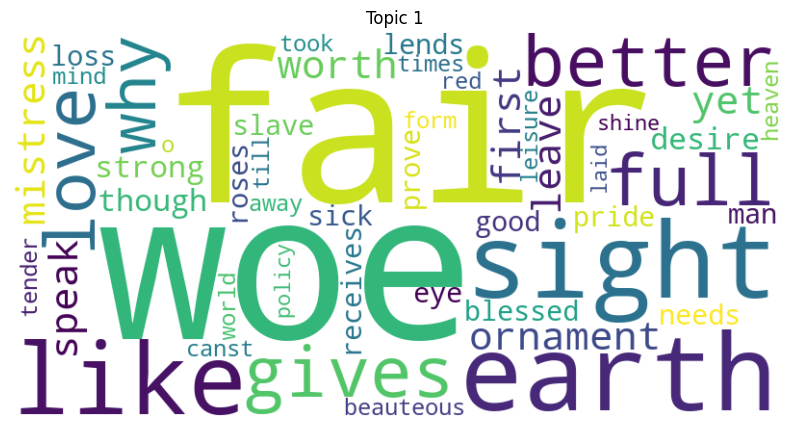

Top words for Topic 1: woe, fair, sight, earth, gives, like, full, love, better, why


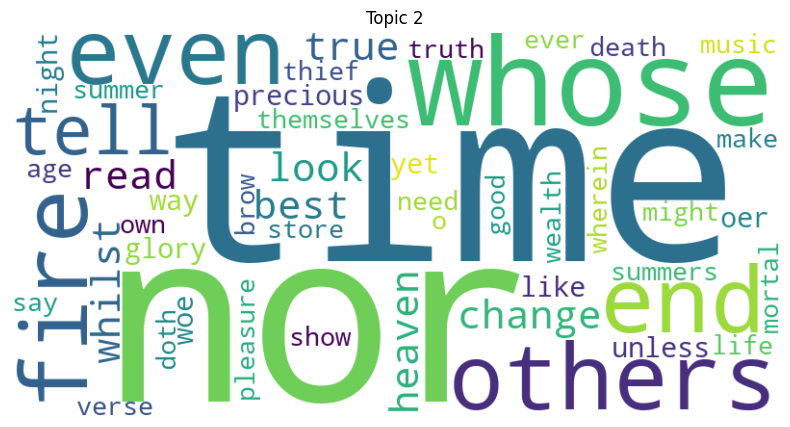

Top words for Topic 2: nor, time, others, whose, fire, tell, end, even, look, heaven


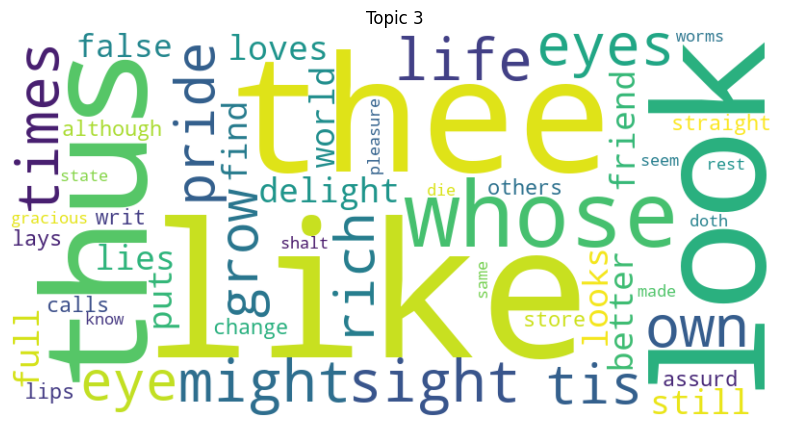

Top words for Topic 3: like, thee, look, thus, whose, times, life, might, eyes, own


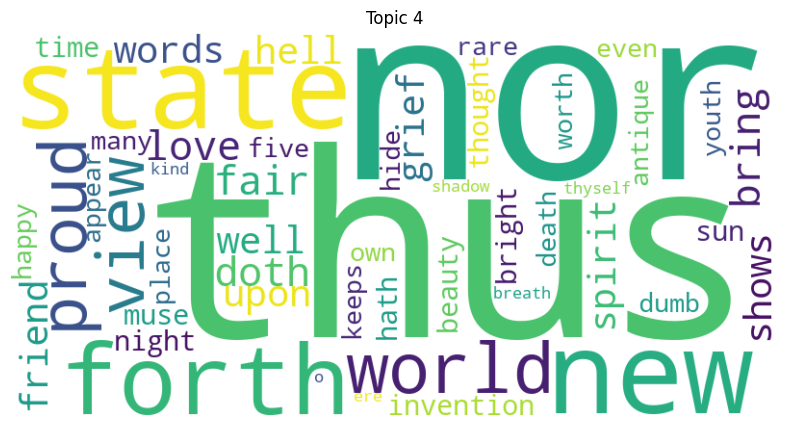

Top words for Topic 4: thus, nor, new, state, world, forth, fair, love, view, bring


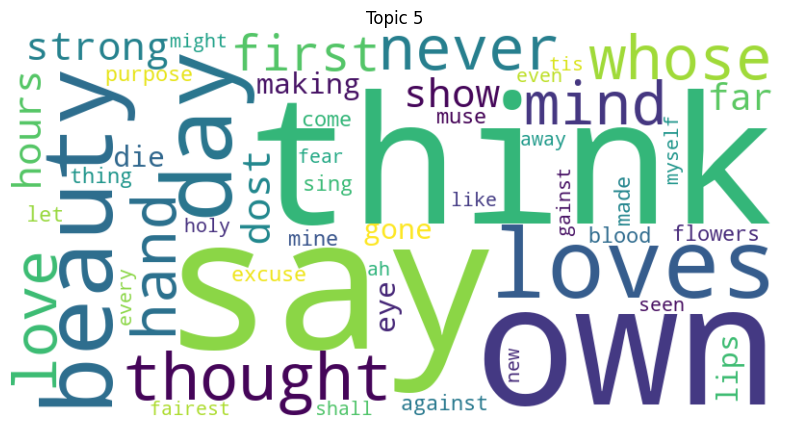

Top words for Topic 5: say, think, own, beauty, loves, day, thought, mind, love, first


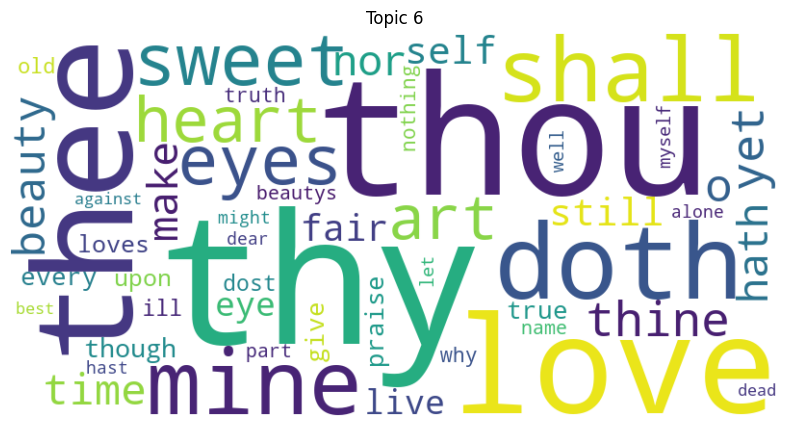

Top words for Topic 6: thy, thou, thee, love, doth, mine, shall, sweet, eyes, heart
Done!


In [ ]:


def load_data(file_path):
    """
    Load and preprocess data from a text file.
    Each line is treated as a separate document.
    """
    with open(file_path, 'r') as f:
        lines = f.read().strip().split('\n')
    
    # If there's only one line, it could be one document with all words
    # or multiple documents concatenated (as in the sonnet case)
    if len(lines) == 1:
        # Split by whitespace to get all words
        all_words = lines[0].split()
        
        # Assuming approximately 140 words per sonnet
        sonnet_length = 140
        
        # Split into multiple documents
        docs = []
        for i in range(0, len(all_words), sonnet_length):
            doc = all_words[i:i+sonnet_length]
            if doc:  # Make sure we don't add empty docs
                docs.append(doc)
    else:
        # Multiple lines, each line is a document
        docs = [line.split() for line in lines]
    
    # Create vocabulary
    vocabulary = set()
    for doc in docs:
        for word in doc:
            vocabulary.add(word)
    vocabulary = list(vocabulary)
    
    # Create word-to-index mapping
    word_to_idx = {word: i for i, word in enumerate(vocabulary)}
    
    # Convert documents to word index arrays
    indexed_docs = []
    for doc in docs:
        doc_indices = [word_to_idx[word] for word in doc]
        indexed_docs.append(doc_indices)
    
    return indexed_docs, vocabulary


def implement_baby_lda(docs, vocab, K=6, alpha=5, beta=2, num_iterations=1000):
    """
    Implement LDA using Gibbs sampling as outlined in Problem 3.
    
    Parameters:
    docs: list of lists
        Each inner list contains word indices for a document
    vocab: list
        List of all unique words
    K: int
        Number of topics
    alpha, beta: float
        Dirichlet priors
    num_iterations: int
        Number of Gibbs sampling iterations
    
    Returns:
    Z: list of lists
        Topic assignments for each word
    A: ndarray
        Document-topic count matrix
    B: ndarray
        Topic-word count matrix
    """
    # Number of documents and vocabulary size
    N = len(docs)
    W = len(vocab)
    
    # Find maximum document length for Z matrix
    max_doc_length = max(len(doc) for doc in docs)
    
    # Initialize matrices as described in the pseudocode
    A = np.ones((N, K)) * alpha  # Document-topic counts
    B = np.ones((K, W)) * beta   # Topic-word counts
    BSUM = np.sum(B, axis=1)     # Sum of counts for each topic
    
    # Initialize topic assignments
    Z = [[-1 for _ in range(max_doc_length)] for _ in range(N)] 
    
    # Random initial assignment as described in the pseudocode
    for d in range(N):
        for i in range(len(docs[d])):
            word = docs[d][i]
            # Random topic assignment
            topic = np.random.randint(0, K)
            Z[d][i] = topic
            
            # Update counts
            A[d, topic] += 1
            B[topic, word] += 1
            BSUM[topic] += 1
    
    # Run Gibbs sampling iterations
    for iter in range(num_iterations):
        for d in range(N):
            for i in range(len(docs[d])):
                word = docs[d][i]
                old_topic = Z[d][i]
                
                # Remove current topic assignment from counts
                if old_topic != -1:  # Ensure there's a valid assignment
                    A[d, old_topic] -= 1
                    B[old_topic, word] -= 1
                    BSUM[old_topic] -= 1
                
                # Calculate conditional distribution
                # p(topic|all else) ∝ A[d,:] .* (B[:,word] ./ BSUM)
                dist = A[d, :] * (B[:, word] / BSUM)
                
                # Normalize to get a proper distribution
                dist = dist / np.sum(dist)
                
                # Sample new topic
                new_topic = np.random.choice(K, p=dist)
                
                # Update Z and counts
                Z[d][i] = new_topic
                A[d, new_topic] += 1
                B[new_topic, word] += 1
                BSUM[new_topic] += 1
        
        # Print progress every 100 iterations
        if (iter + 1) % 100 == 0:
            print(f"Completed {iter + 1}/{num_iterations} iterations")
    
    return Z, A, B


def create_wordclouds(B, vocab, K):
    """
    Create wordclouds for each topic using the topic-word matrix B.
    """
    for k in range(K):
        # Create a dictionary of word:weight pairs
        word_weights = {vocab[w]: float(B[k, w]) for w in range(len(vocab))}
        
        # Generate wordcloud
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            max_words=50,
            colormap='viridis'
        ).generate_from_frequencies(word_weights)
        
        # Display and save
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {k+1}')
        plt.axis('off')
        plt.savefig(f'topic_{k+1}_wordcloud.png')
        plt.show()
        
        # Print top words for this topic
        top_indices = np.argsort(B[k, :])[-10:][::-1]
        top_words = [vocab[idx] for idx in top_indices]
        print(f"Top words for Topic {k+1}: {', '.join(top_words)}")

# Main execution
# Load the sonnet data
file_path = os.environ.get("SONNETS_DATASET_PATH") + "sonnets.txt"
docs, vocab = load_data(file_path)
print(f"Loaded {len(docs)} documents with vocabulary size {len(vocab)}")

# Set parameters
K = 6  # Number of topics as specified in Problem 3
alpha = 5  # As specified in Problem 3
beta = 2  # As specified in Problem 3

# Run LDA
print("Running LDA with Gibbs sampling...")
Z, A, B = implement_baby_lda(docs, vocab, K=K, alpha=alpha, beta=beta, num_iterations=1000)

# Create wordclouds
print("Generating wordclouds...")
create_wordclouds(B, vocab, K)

print("Done!")